In [2]:
from typing import Dict, Text 
import pprint
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
print(tf.__version__)
print(tfrs.__version__)
import matplotlib.pyplot as plt


2.10.0
v0.7.2


In [4]:
# Load the movielens dataset
ratings = tfds.load("movielens/1m-ratings", split="train")
movies = tfds.load("movielens/1m-movies", split="train")

In [5]:
# ratings_df = tfds.as_dataframe(ratings)


In [6]:
# users_with_favorable_ratings = (ratings['user_id'].value_counts()
#                                 .loc[lambda x: x>10]
#                                 .loc[lambda x: x<100]
#                                 .index.values)

# ratings = ratings[ratings_df['user_id'].isin(users_with_favorable_ratings)]

In [7]:
# ratings = tf.data.Dataset.from_tensor_slices(ratings)


In [ ]:
ratings = ratings.map(lambda x: {
    'movie_title': x['movie_title'],
    'user_id': x['user_id'],
    'user_rating': x['user_rating'],
    'timestamp': x['timestamp'],
    'age': x['age']
})


In [30]:
# Load the movielens dataset
ratings = tfds.load("movielens/1m-ratings", split="train")
movies = tfds.load("movielens/1m-movies", split="train")
#Choosing movie features 
ratings = ratings.map(lambda x: {
    'movie_title': x['movie_title'],
    'user_id': x['user_id'],
    'user_rating': x['user_rating'],
    'timestamp': x['timestamp']
})

movies = movies.map(lambda x: x['movie_title'])

timestamps = np.concatenate(list(
    ratings.map(lambda x: x['timestamp']).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x['user_id']))))

print(len(unique_movie_titles), len(unique_user_ids))

# Count the number of ratings per movie
movie_ratings_count = ratings.map(lambda x: x['movie_title']).batch(1000).reduce_count().numpy()

# Create a dictionary that maps movie titles to their popularity
movie_popularity = dict(zip(unique_movie_titles, movie_ratings_count))

# Add a new feature to the movie dataset that represents the popularity of the movie
movies = movies.map(lambda x: {'movie_title': x, 'popularity': movie_popularity[x]})

3883 6040


AttributeError: 'BatchDataset' object has no attribute 'reduce_count'

AttributeError: 'BatchDataset' object has no attribute 'reduce_count'

### User Model

In [6]:

class UserModel(tf.keras.Model):
# User embedding will be user id + ts + normalized ts embeddings

    def __init__(self, use_timestamps):
        super().__init__()
        
        self._use_timestamps = use_timestamps
        
        # User id embedding
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids,
                mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids)+1, 32)
        ])
        
        if use_timestamps:
            # Use timestamp
            self.timestamp_embedding = tf.keras.Sequential([
                tf.keras.layers.Discretization(timestamp_buckets.tolist()),
                tf.keras.layers.Embedding(len(timestamp_buckets)+1, 32)
            ])

            # Normalized timestamp
            self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
            self.normalized_timestamp.adapt(timestamps)
        
    
    def call(self, inputs): #Call method to concatenate features into single vector
        if not self._use_timestamps:
            return self.user_embedding(inputs['user_id'])
        
        return tf.concat([
            self.user_embedding(inputs['user_id']),
            self.timestamp_embedding(inputs['timestamp']),
            tf.reshape(self.normalized_timestamp(inputs['timestamp']),(-1,1))
        ], axis=1) 

### Movie Model

In [7]:
class MovieModel(tf.keras.Model):
    # Movie embedding: title text + id 
    
    def __init__(self, use_title_text):
        super().__init__()
        max_tokens = 10_000
        
        self._use_title_text = use_title_text
        
        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles)+1, 32)
        ])
        
        if use_title_text:
            self.title_vectorizer = tf.keras.layers.TextVectorization(
                max_tokens=max_tokens)
            self.title_vectorizer.adapt(movies)

            self.title_text_embedding = tf.keras.Sequential([
                self.title_vectorizer,
                tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
                tf.keras.layers.GlobalAveragePooling1D()
            ])
        
        
    def call(self, inputs):
        if not self._use_title_text:
            return self.title_embedding(inputs)
        
        return tf.concat([
            self.title_embedding(inputs),
            self.title_text_embedding(inputs)
        ], axis=1)


### Combined Model

In [8]:

class MovielensModel(tfrs.models.Model):
    
    def __init__(self, use_timestamps=True, use_title_text=True):
        super().__init__()
        
        self.rating_weight = 0.5
        self.retrieval_weight = 0.5
        
        # User and Movie models
        self.user_model = tf.keras.Sequential([
            UserModel(use_timestamps),
            tf.keras.layers.Dense(32)
        ])
        self.movie_model = tf.keras.Sequential([
            MovieModel(use_title_text),
            tf.keras.layers.Dense(32)
        ])
        
	# Ranking model with DCN using keras Functional API
        x0 = tf.keras.Input(shape=(64,))
        x1 = tfrs.layers.dcn.Cross()(x0, x0)
        x2 = tfrs.layers.dcn.Cross()(x0, x1)
        d1 = tf.keras.layers.Dense(256, activation='relu')(x2)
        d2 = tf.keras.layers.Dense(256, activation='relu')(d1) #64,128,192
        output = tf.keras.layers.Dense(1)(d2)
        self.rating_model = tf.keras.Model(inputs=x0, outputs=output)
    
        # Multi-tasks
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.movie_model) 
            )
        )
            
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_embeddings = self.user_model({
            'user_id': features['user_id'],
            'timestamp': features['timestamp']
        })
        movie_embeddings = self.movie_model(
            features['movie_title']
        )
        return (
            user_embeddings, 
            movie_embeddings,
            self.rating_model(tf.concat([
                user_embeddings,
                movie_embeddings
            ], axis=1))
        )
        
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings, movie_embeddings, rating_predictions = self.call(features)
        # Retrieval loss
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)
        # Rating loss
        rating_loss = self.rating_task(
            labels=features['user_rating'],
            predictions=rating_predictions
        )
        
        # Combine two losses with hyper-parameters (to be tuned)
        return (self.rating_weight * rating_loss \
                + self.retrieval_weight * retrieval_loss)

In [9]:
# Prepare data
tf.random.set_seed(7)
shuffled = ratings.shuffle(100_000, seed=42,
                reshuffle_each_iteration=True)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)#80:20 split

cached_train = train.shuffle(100_000).batch(2048).cache()
cached_test = test.batch(4096).cache()

In [10]:

model = MovielensModel(use_timestamps=True, use_title_text=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

history=model.fit(cached_train,validation_data=cached_test, epochs=500,)

train_acc = model.evaluate(
    cached_train, return_dict=True)['factorized_top_k/top_100_categorical_accuracy']
test_acc = model.evaluate(
    cached_test, return_dict=True)['factorized_top_k/top_100_categorical_accuracy']

print(f'Top-100 accuracy (train): {train_acc:.2f}')
print(f'Top-100 accuracy (test): {test_acc:.2f}')

Epoch 1/500


40/40 [==============================] - ETA: 0s - root_mean_squared_error: 1.3991 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0044 - factorized_top_k/top_10_categorical_accuracy: 0.0080 - factorized_top_k/top_50_categorical_accuracy: 0.0316 - factorized_top_k/top_100_categorical_accuracy: 0.0561 - loss: 7613.2306 - regularization_loss: 0.0000e+00 - total_loss: 7613.2306WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'user_id': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'timestamp': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>}. Consider rewriting this model with the Functional API.


40/40 [==============================] - 14s 261ms/step - root_mean_squared_error: 1.3991 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0044 - factorized_top_k/top_10_categorical_accuracy: 0.0080 - factorized_top_k/top_50_categorical_accuracy: 0.0316 - factorized_top_k/top_100_categorical_accuracy: 0.0561 - loss: 7435.1068 - regularization_loss: 0.0000e+00 - total_loss: 7435.1068 - val_root_mean_squared_error: 1.1146 - val_factorized_top_k/top_1_categorical_accuracy: 0.0010 - val_factorized_top_k/top_5_categorical_accuracy: 0.0053 - val_factorized_top_k/top_10_categorical_accuracy: 0.0098 - val_factorized_top_k/top_50_categorical_accuracy: 0.0391 - val_factorized_top_k/top_100_categorical_accuracy: 0.0730 - val_loss: 14732.8965 - val_regularization_loss: 0.0000e+00 - val_total_loss: 14732.8965
Epoch 2/500
40/40 [==============================] - 8s 203ms/step - root_mean_squared_error: 1.1117 - factorized_top_k/top_1_categorical_

In [11]:
model.evaluate(cached_test, return_dict=True)


5/5 [==============================] - 1s 262ms/step - root_mean_squared_error: 1.1096 - factorized_top_k/top_1_categorical_accuracy: 0.0194 - factorized_top_k/top_5_categorical_accuracy: 0.1163 - factorized_top_k/top_10_categorical_accuracy: 0.1758 - factorized_top_k/top_50_categorical_accuracy: 0.2855 - factorized_top_k/top_100_categorical_accuracy: 0.3513 - loss: 26313.1410 - regularization_loss: 0.0000e+00 - total_loss: 26313.1410


{'root_mean_squared_error': 1.1095962524414062,
 'factorized_top_k/top_1_categorical_accuracy': 0.019449999555945396,
 'factorized_top_k/top_5_categorical_accuracy': 0.11625000089406967,
 'factorized_top_k/top_10_categorical_accuracy': 0.17579999566078186,
 'factorized_top_k/top_50_categorical_accuracy': 0.2854999899864197,
 'factorized_top_k/top_100_categorical_accuracy': 0.3513000011444092,
 'loss': 25273.47265625,
 'regularization_loss': 0,
 'total_loss': 25273.47265625}

In [12]:
print(history.history.keys())

dict_keys(['root_mean_squared_error', 'factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss', 'val_root_mean_squared_error', 'val_factorized_top_k/top_1_categorical_accuracy', 'val_factorized_top_k/top_5_categorical_accuracy', 'val_factorized_top_k/top_10_categorical_accuracy', 'val_factorized_top_k/top_50_categorical_accuracy', 'val_factorized_top_k/top_100_categorical_accuracy', 'val_loss', 'val_regularization_loss', 'val_total_loss'])


In [13]:
#notice how back the accuracy is when only prediction the top 10 since no scores are input
plt.figure(figsize=(12,6))
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], label = "Validation Top 100")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_100_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_100_categorical_accuracy"])),
                     history.history["factorized_top_k/top_100_categorical_accuracy"], label = "Training Top 100")
plt.plot(epochs, history.history["val_factorized_top_k/top_10_categorical_accuracy"], label = "Validation Top 10")
plt.plot(np.linspace(1, len( history.history["factorized_top_k/top_10_categorical_accuracy"]), 
                     len( history.history["factorized_top_k/top_10_categorical_accuracy"])),
                     history.history["factorized_top_k/top_10_categorical_accuracy"], label = "Training Top 10")
plt.title("Top-100 vs Top-10 Recommendations")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

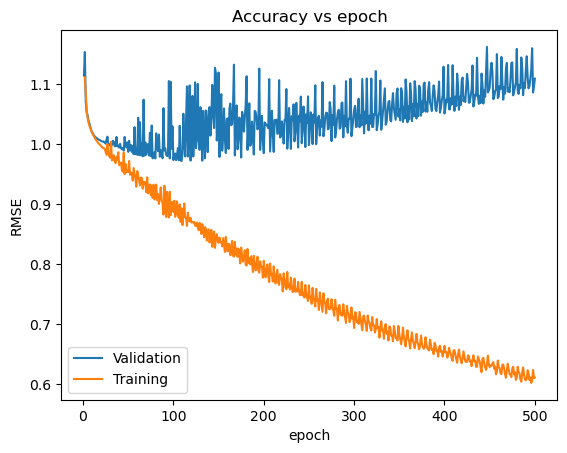

In [14]:
num_validation_runs = len(history.history["val_root_mean_squared_error"])
epochs_val = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs_val, history.history["val_root_mean_squared_error"], label = "Validation")
plt.plot(np.linspace(1, len( history.history["root_mean_squared_error"]), 
                     len( history.history["root_mean_squared_error"]))[1:],
                     history.history["root_mean_squared_error"][1:], label = "Training")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

AttributeError: 'MapDataset' object has no attribute 'random_split'

In [17]:
# tf.saved_model.save(model,'Recommender_System/models/movie_ranking_model')

### Testing model

### recommendation :

In [30]:
test_ratings = {}
for m in test.take(5):
#     print(m['movie_title'].numpy())
    _, _, test_ratings[m['movie_title'].numpy()] = \
        model(
            {'user_id':np.array(['42']), 
             'timestamp':np.array([892839492]), 
             'movie_title': np.array([m['movie_title'].numpy()])
            }
        )
    
for m in sorted(test_ratings, key=test_ratings.get, reverse=True):
    print(m)

b'Sixteen Candles (1984)'
b'Coneheads (1993)'
b'Evil Dead II (Dead By Dawn) (1987)'
b'It Happened One Night (1934)'
b'Notting Hill (1999)'


### prediction

In [31]:
for r in test_ratings: 
    print(r, test_ratings[r].numpy()[0][0])

b'Notting Hill (1999)' 1.8778979
b'Coneheads (1993)' 4.3385572
b'Sixteen Candles (1984)' 4.737164
b'It Happened One Night (1934)' 3.3900332
b'Evil Dead II (Dead By Dawn) (1987)' 4.0089626


In [27]:
model.summary()

Model: "movielens_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  multiple                  227459    
                                                                 
 sequential_17 (Sequential)  (None, 32)                446368    
                                                                 
 model_2 (Functional)        (None, 1)                 41473     
                                                                 
 ranking_2 (Ranking)         multiple                  0         
                                                                 
 retrieval_2 (Retrieval)     multiple                  1         
                                                                 
Total params: 715,301
Trainable params: 715,297
Non-trainable params: 4
_________________________________________________________________


In [22]:
def calculate_popularity_bias(ratings, k, model):
    # Count the number of ratings for each movie
    movie_counts = ratings.map(lambda x: x['movie_title']).batch(1000)
    movie_counts = tf.data.Dataset.from_tensor_slices(movie_counts)
    movie_counts = movie_counts.group_by_window(
        key_func=lambda x: x, reduce_func=tf.data.Dataset.from_tensor_slices, window_size=1
    )
    movie_counts = movie_counts.map(lambda _, ds: tf.size(ds))
    movie_counts = dict(zip(unique_movie_titles, movie_counts))

    # Sort the movies by popularity
    sorted_movies = sorted(movie_counts, key=movie_counts.get, reverse=True)

    # Get the top k movies
    top_k_movies = sorted_movies[:k]

    # Get the total number of recommendations
    total_recs = 0
    for movie in top_k_movies:
        total_recs += movie_counts[movie]

    # Get the number of recommendations that came from the top k movies
    top_k_recs = 0
    for movie, count in movie_counts.items():
        if movie in top_k_movies:
            top_k_recs += count

    # Calculate the proportion of recommendations that came from the top k movies
    popularity_bias = top_k_recs / total_recs
    return popularity_bias



This function would return a number between 0 and 1, where 0 means there is no popularity bias and 1 means that all recommendations are for the most popular items.

It is important to note that the threshold k can be modified to reflect the level of popularity that's acceptable for the system, it can be set to a high number (e.g. 1000) if the dataset is large, or set to a lower number if the dataset is small.

In [23]:
popularity_bias = calculate_popularity_bias(ratings, k=500, model=model)
print("Popularity bias: {:.2f}".format(popularity_bias))


ValueError: Slicing dataset elements is not supported for rank 0.

In [ ]:
#function that takes in the user data and a list of recommended items, and then calculates the demographic parity score 
def demographic_parity(user_data: Dict[Text, Any], recommendations: List[Text]) -> float:
    protected_group_count = user_data[user_data['protected_group'] == 1].count()
    total_count = user_data.count()
    protected_group_recommendations = recommendations[recommendations['protected_group'] == 1].count()
    return protected_group_recommendations / protected_group_count - total_count
# use this function to calculate the demographic parity score on a test set of user data and recommendations, and use the score as a metric to measure bias in the system.